In [1]:
!pip install fvcore
from fvcore.nn import FlopCountAnalysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=fddd86da4e14cad8c4b8b9c71996f7523c8d54ffb1f6d36b71636354206a1f5e
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=dde29660450b8eb23e581195e3a3959ffd78b95c69c6117662af5a5928e42cdb
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath


In [2]:
#ONY FOR MODIFICATION 8
#CUSTOM CUDA KERNAL AS INLINE
!pip install pybind11
!rm -rf ~/.cache/torch_extensions/inertial_conv_ext_v2* #clear the GPU cache

In [3]:
# ONLY FOR MODIFICATION 8
# CUSTOM CUDA KERNEL AS INLINE
# INSPIRED BY DeepSeek’s setup

from torch.utils.cpp_extension import load_inline

# 1) Host-binding C++ (no __global__, just the PYBIND11_MODULE)
cpp_src = r'''
#include <torch/extension.h>

// forward declaration of the CUDA implementation
torch::Tensor inertial_conv_forward(
    torch::Tensor input,
    torch::Tensor core,
    torch::Tensor perip,
    torch::Tensor thresh,
    torch::Tensor scale,
    int stride,
    int padding
);

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
    m.def("forward", &inertial_conv_forward, "InertialConv forward (CUDA)");
}
'''

# 2) Device + implementation in CUDA (no changes needed here)
cuda_src = r'''
#include <torch/extension.h>

// kernel: for each (b, oc, y, x) compute inertial conv
template <typename scalar_t>
__global__ void inertial_conv_kernel(
    const scalar_t* __restrict__ input,
    const scalar_t* __restrict__ core,
    const scalar_t* __restrict__ perip,
    const scalar_t* __restrict__ thresh,
    scalar_t scale,
    scalar_t* __restrict__ output,
    int B, int C, int H, int W,
    int OC, int stride, int pad
) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int Hout = (H + 2*pad - 3) / stride + 1;
    int Wout = (W + 2*pad - 3) / stride + 1;
    int total = B * OC * Hout * Wout;
    if (idx >= total) return;

    // decode idx -> b, oc, oy, ox
    int tmp = idx;
    int ox = tmp % Wout; tmp /= Wout;
    int oy = tmp % Hout; tmp /= Hout;
    int oc = tmp % OC;   tmp /= OC;
    int b  = tmp;

    int in_row = oy*stride - pad;
    int in_col = ox*stride - pad;
    const scalar_t* inp_base = input + b*C*H*W;
    scalar_t sum_div = 0, core_out = 0, detp_out = 0;

    // loop over channels
    for (int c = 0; c < C; ++c) {
        // center pixel
        int cy = in_row + 1, cx = in_col + 1;
        scalar_t center = 0;
        if (cy >= 0 && cy < H && cx >= 0 && cx < W)
            center = inp_base[c*H*W + cy*W + cx];

        // core conv (1×1)
        scalar_t w_core = core[oc*C + c];
        core_out += center * w_core;

        // 8 neighbors
        static const int offs[8][2] = {
            {-1,-1},{-1,0},{-1,1},
            { 0,-1},       { 0,1},
            { 1,-1},{ 1,0},{ 1,1}
        };
        for (int i = 0; i < 8; ++i) {
            int ny = cy + offs[i][0];
            int nx = cx + offs[i][1];
            scalar_t pix = 0;
            if (ny >= 0 && ny < H && nx >= 0 && nx < W)
                pix = inp_base[c*H*W + ny*W + nx];
            scalar_t diff = pix - center;
            sum_div += diff*diff;
            detp_out += pix * (perip[i] * w_core);
        }
    }

    // mask (STE)
    scalar_t d = sum_div;
    scalar_t m = 1.0f / (1.0f + expf(-(d - thresh[oc]) * scale));
    scalar_t mh = m > 0.5f ? 1.0f : 0.0f;
    scalar_t mask = mh - m + m;

    // write
    output[idx] = core_out * (1 - mask) + detp_out * mask;
}

torch::Tensor inertial_conv_forward(
    torch::Tensor input,
    torch::Tensor core,
    torch::Tensor perip,
    torch::Tensor thresh,
    torch::Tensor scale,
    int stride,
    int padding
) {
    auto B = input.size(0), C = input.size(1),
         H = input.size(2), W = input.size(3);
    auto OC = core.size(0);
    int Hout = (H + 2*padding - 3) / stride + 1;
    int Wout = (W + 2*padding - 3) / stride + 1;
    auto out = torch::zeros({B, OC, Hout, Wout}, input.options());

    int total = B * OC * Hout * Wout;
    int threads = 256;
    int blocks = (total + threads - 1) / threads;

    AT_DISPATCH_FLOATING_TYPES(input.scalar_type(), "inertial_conv_cuda", ([&](){
        inertial_conv_kernel<scalar_t><<<blocks, threads>>>(
            input.data_ptr<scalar_t>(),
            core.data_ptr<scalar_t>(),
            perip.data_ptr<scalar_t>(),
            thresh.data_ptr<scalar_t>(),
            scale.item<scalar_t>(),
            out.data_ptr<scalar_t>(),
            B, C, H, W, OC, stride, padding
        );
    }));
    cudaDeviceSynchronize();
    return out;
}
'''

# 3) Compile both together (remove functions parameter)
inertial_ext = load_inline(
    name="inertial_conv_ext_v2",
    cpp_sources=[cpp_src],
    cuda_sources=[cuda_src],
    with_cuda=True,
    extra_cuda_cflags=["--use_fast_math"],
)

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [4]:
# ONLY FOR MODIFICATION 9: GENERIC d×d / k×k INERTIAL CONV (CUDA-FUSION)
#Host-binding C++
cpp_src_g = r'''
#include <torch/extension.h>

torch::Tensor inertial_conv_generic_forward(
    torch::Tensor input,
    torch::Tensor core,    // [OC, C, K, K]
    torch::Tensor perip,   // [D*D – K*K]
    torch::Tensor thresh,  // [OC]
    torch::Tensor scale,   // scalar
    int D,
    int K,
    int stride,
    int padding
);

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
  m.def("forward", &inertial_conv_generic_forward, "Generic InertialConv (CUDA)");
}
'''

# 2) Device + implementation in CUDA
cuda_src_g = r'''
#include <torch/extension.h>

template <typename scalar_t>
__global__ void inertial_conv_kernel_generic(
    const scalar_t* __restrict__ input,  // B*C*H*W
    const scalar_t* __restrict__ core,   // OC*C*K*K
    const scalar_t* __restrict__ perip,  // D*D - K*K
    const scalar_t* __restrict__ thresh, // OC
    scalar_t scale,
    scalar_t* __restrict__ output,       // B*OC*Hout*Wout
    int B, int C, int H, int W,
    int OC, int D, int K, int stride, int pad
) {
    int idx = blockIdx.x*blockDim.x + threadIdx.x;
    int Hout = (H + 2*pad - D)/stride + 1;
    int Wout = (W + 2*pad - D)/stride + 1;
    int total = B*OC*Hout*Wout;
    if (idx >= total) return;

    // decode (b,oc,oy,ox)
    int tmp = idx;
    int ox  = tmp % Wout;  tmp /= Wout;
    int oy  = tmp % Hout;  tmp /= Hout;
    int oc  = tmp % OC;    tmp /= OC;
    int b   = tmp;

    const scalar_t* inp    = input + b*C*H*W;
    const scalar_t* core_w = core  + oc*C*K*K;
    const scalar_t* th     = thresh + oc;
    int cen_i = oy*stride - pad + D/2;
    int cen_j = ox*stride - pad + D/2;

    scalar_t sum_div = 0, core_out = 0, detp_out = 0;

    // compute central‐patch convolution (KxK core)
    for (int c=0; c<C; ++c) {
      for (int ki=0; ki<K; ++ki) {
        for (int kj=0; kj<K; ++kj) {
          int yi = cen_i - (K/2) + ki;
          int xj = cen_j - (K/2) + kj;
          scalar_t pix = 0;
          if (yi>=0 && yi<H && xj>=0 && xj<W)
            pix = inp[c*H*W + yi*W + xj];
          core_out += pix * core_w[c*K*K + ki*K + kj];
        }
      }
    }

    // gather periphery divergences & weighted sum
    int per_idx = 0;
    for (int di = 0; di < D; ++di) {
      for (int dj = 0; dj < D; ++dj) {
        // skip core region
        if (di >= (D-K)/2 && di < (D+K)/2 &&
            dj >= (D-K)/2 && dj < (D+K)/2) {
          continue;
        }
        scalar_t perip_val = perip[per_idx];
        per_idx++;

        // Loop over input channels
        for (int c = 0; c < C; ++c) {
          int yi = oy*stride - pad + di;
          int xj = ox*stride - pad + dj;
          scalar_t pix = 0;
          if (yi>=0 && yi<H && xj>=0 && xj<W)
            pix = inp[c*H*W + yi*W + xj];
          scalar_t center = inp[c*H*W + cen_i*W + cen_j];
          scalar_t diff = pix - center;
          sum_div += diff * diff;
          
          // Get central weight for this channel
          scalar_t w0 = core_w[c*K*K + (K/2)*K + (K/2)];
          detp_out += pix * (perip_val * w0);
        }
      }
    }

    // STE mask
    scalar_t d = sum_div;
    scalar_t m = 1.0f / (1.0f + expf(-(d - *th) * scale));
    scalar_t mh = m > 0.5f ? 1.0f : 0.0f;
    scalar_t mask = mh - m + m;

    // write
    output[idx] = core_out * (1-mask) + detp_out * mask;
}

torch::Tensor inertial_conv_generic_forward(
    torch::Tensor input,
    torch::Tensor core,
    torch::Tensor perip,
    torch::Tensor thresh,
    torch::Tensor scale,
    int D,
    int K,
    int stride,
    int padding
) {
    auto B = input.size(0), C = input.size(1),
         H = input.size(2), W = input.size(3);
    auto OC = core.size(0);
    int Hout = (H + 2*padding - D)/stride + 1;
    int Wout = (W + 2*padding - D)/stride + 1;
    auto out = torch::zeros({B,OC,Hout,Wout}, input.options());

    int total = B*OC*Hout*Wout;
    int threads = 256;
    int blocks  = (total + threads - 1)/threads;

    AT_DISPATCH_FLOATING_TYPES(input.scalar_type(), "inertial_conv_generic", ([&](){
        inertial_conv_kernel_generic<scalar_t><<<blocks,threads>>>(
            input.data_ptr<scalar_t>(),
            core.data_ptr<scalar_t>(),
            perip.data_ptr<scalar_t>(),
            thresh.data_ptr<scalar_t>(),
            scale.item<scalar_t>(),
            out.data_ptr<scalar_t>(),
            B, C, H, W, OC, D, K, stride, padding
        );
    }));
    cudaDeviceSynchronize();
    return out;
}
'''

inertial_ext_generic = load_inline(
    name="inertial_conv_ext_generic",
    cpp_sources=[cpp_src_g],
    cuda_sources=[cuda_src_g],
    with_cuda=True,
    extra_cuda_cflags=["--use_fast_math"],
)

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 42.1MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.81MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw




LeNet 3x3:
  Params: 1,199,882
  FLOPs: 767,516,672
  Runtime: 1.32 ms
  Accuracy: 0.0600
  F1 Score: 0.0120
  Precision: 0.0065
  Recall: 0.0750

LeNet 1x1:
  Params: 1,609,226
  FLOPs: 207,208,448
  Runtime: 1.09 ms
  Accuracy: 0.1500
  F1 Score: 0.0584
  Precision: 0.0471
  Recall: 0.1300

Original Inertial:
  Params: 1,183,148
  FLOPs: 1,459,453,952
  Runtime: 5.80 ms
  Accuracy: 0.1500
  F1 Score: 0.0806
  Precision: 0.1460
  Recall: 0.1481

Optimized Modification 1:
  Params: 1,183,148
  FLOPs: 844,401,172.0
  Runtime: 3.96 ms
  Accuracy: 0.1500
  F1 Score: 0.0806
  Precision: 0.1460
  Recall: 0.1481

Optimized Modification 2:
  Params: 1,183,148
  FLOPs: 194,523,124.0
  Runtime: 4.90 ms
  Accuracy: 0.0700
  F1 Score: 0.0444
  Precision: 0.0363
  Recall: 0.1287

Optimized Modification 3:
  Params: 1,201,870
  FLOPs: 488,935,168
  Runtime: 4.85 ms
  Accuracy: 0.1400
  F1 Score: 0.0447
  Precision: 0.0438
  Recall: 0.1019

Optimized Modification 4:
  Params: 1,183,166
  FLOPs: 152

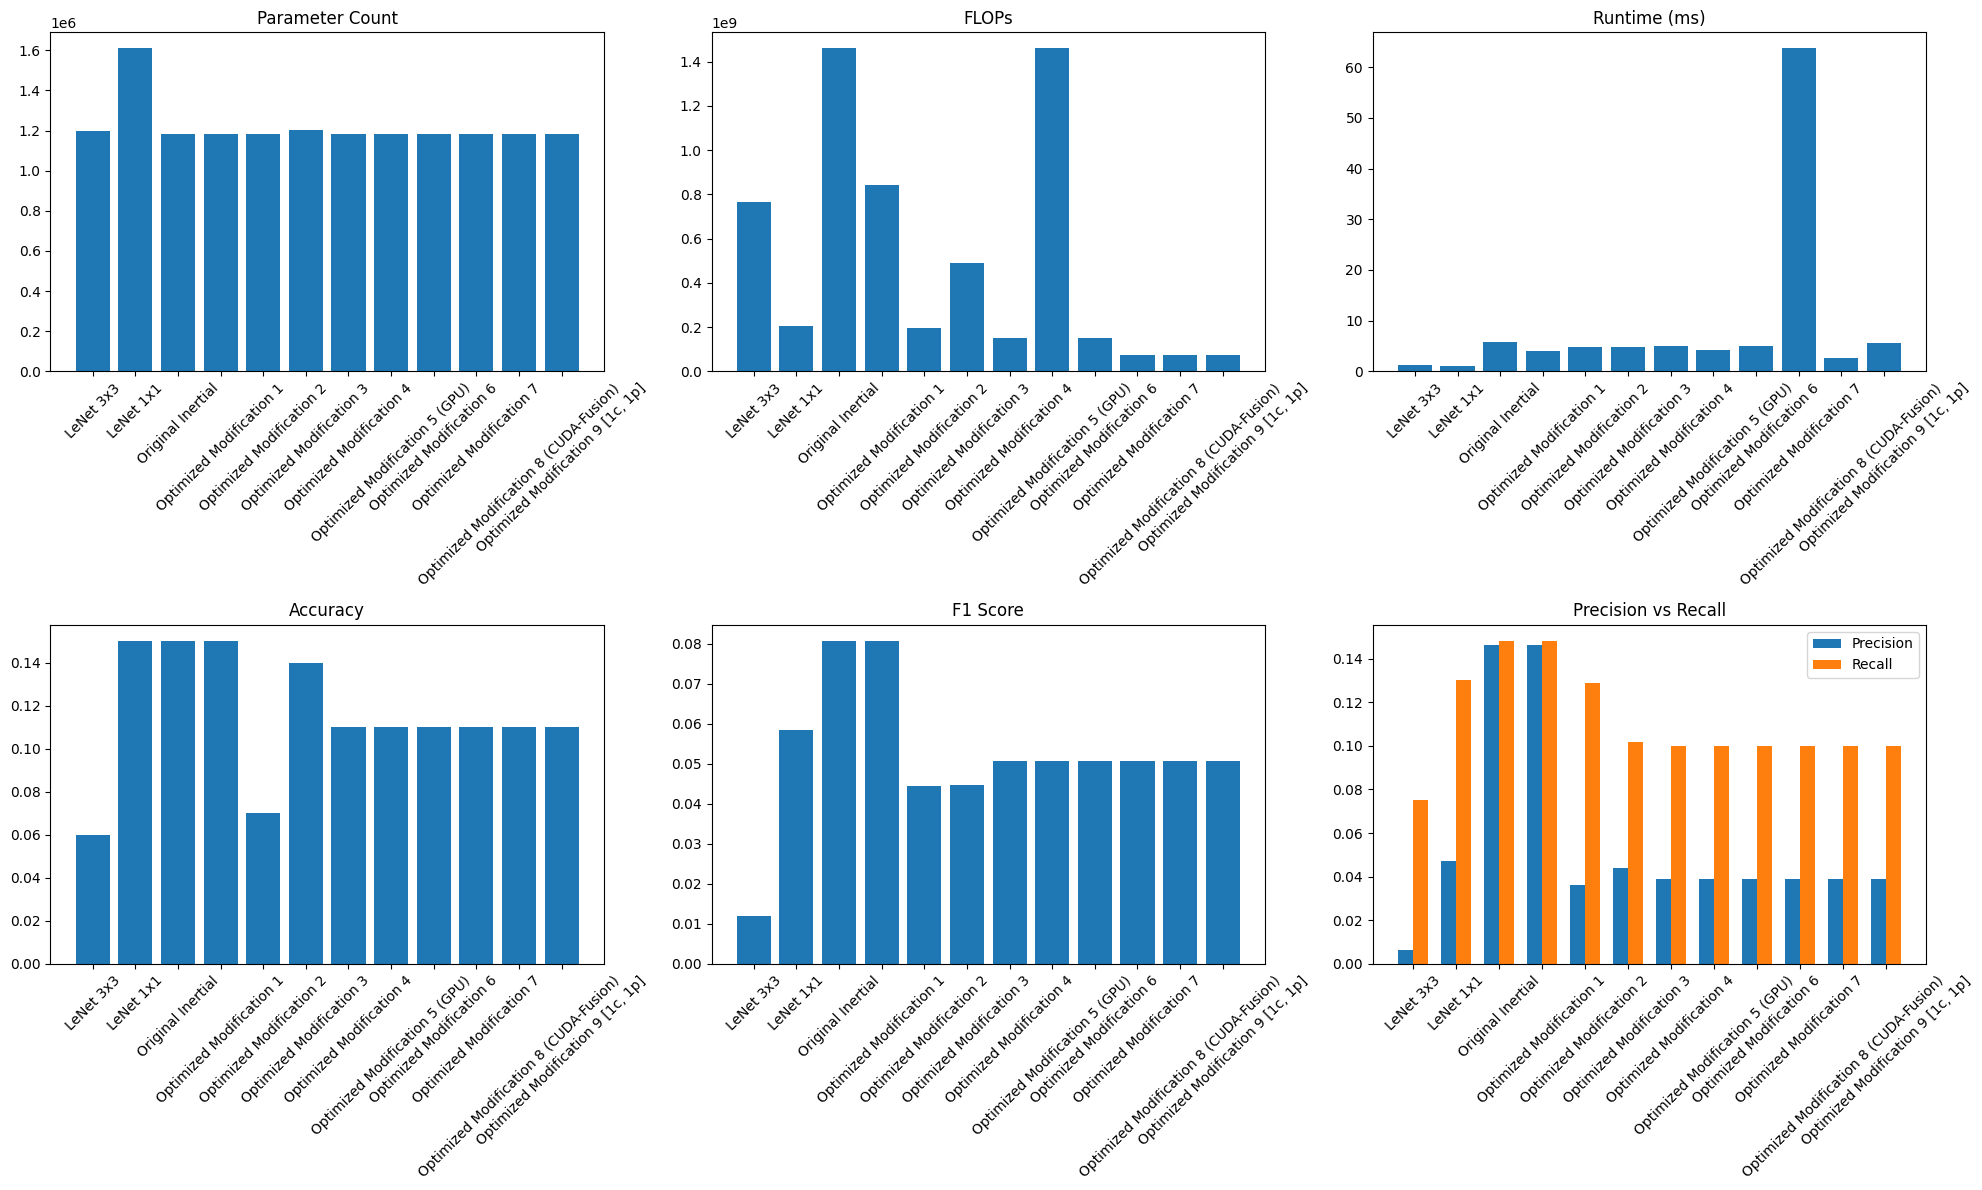

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Subset
import numpy as np
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# ===== Configuration =====
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
SUBSET_SIZE = 100  # For quick testing
SEED = 42
torch.manual_seed(SEED)

# ===== Data Loading =====
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load full dataset for evaluation
full_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
full_test = datasets.MNIST('../data', train=False, transform=transform)

# Create small subset for profiling
train_subset = Subset(full_train, indices=range(SUBSET_SIZE))
test_subset = Subset(full_test, indices=range(SUBSET_SIZE))

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=BATCH_SIZE)



# ===== Model Definitions =====
# Baseline 3x3
class LeNet3x3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Baseline 1x1
class LeNet1x1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 1, 1)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Original Inertial
class OriginalInertialConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, threshold_init=0.1):
        super().__init__()
        assert kernel_size == 3, "Kernel size must be 3x3"
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        
        self.core = nn.Parameter(torch.Tensor(out_channels, in_channels, 1, 1))
        self.threshold = nn.Parameter(torch.tensor([threshold_init]))
        nn.init.kaiming_uniform_(self.core)

    def forward(self, x):
        # Core output (3x3 conv with core at center, zeros elsewhere)
        core_kernel = torch.zeros(self.out_channels, self.in_channels, 3, 3, device=x.device)
        core_kernel[:, :, 1, 1] = self.core.squeeze(-1).squeeze(-1)
        core_output = F.conv2d(x, core_kernel, stride=self.stride, padding=0)
        
        # Divergence calculation
        patches = F.unfold(x, kernel_size=3, stride=self.stride, padding=0)
        patches = patches.view(x.size(0), self.in_channels, 9, -1)
        core_values = patches[:, :, 4, :]
        diffs = torch.abs(patches - core_values.unsqueeze(2))
        periphery_diffs = diffs[:, :, [0,1,2,3,5,6,7,8], :]
        divergence = periphery_diffs.sum(dim=(1,2))
        H_out = (x.shape[2] - 3) // self.stride + 1
        W_out = (x.shape[3] - 3) // self.stride + 1
        divergence = divergence.view(x.size(0), H_out, W_out)
        
        # Detailed output (3x3 conv with expanded core, averaged)
        detailed_kernel = self.core.repeat(1, 1, 3, 3)
        detailed_output = F.conv2d(x, detailed_kernel, stride=self.stride, padding=0) / 9.0
        
        # Mask based on threshold
        mask = (divergence > self.threshold).float().unsqueeze(1)
        
        # Combine outputs
        output = mask * detailed_output + (1 - mask) * core_output
        return output

#Optimized Inertial Filters
#Modification 1: Using true 1x1 core filter ops instead of 0-padding
class OptimizedInertialConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, threshold_init=0.1):
        super().__init__()
        assert kernel_size == 3, "Kernel size must be 3x3"
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        # Core 1x1 kernel
        self.core = nn.Parameter(torch.Tensor(out_channels, in_channels, 1, 1))
        
        # Learnable threshold
        self.threshold = nn.Parameter(torch.tensor([threshold_init]))
        
        # Initialize weights
        nn.init.kaiming_uniform_(self.core)

    def forward(self, x):
        # 1. Extract patches once
        patches = F.unfold(x, kernel_size=3, stride=self.stride, padding=0)
        B, C9, L = patches.shape
        patches = patches.view(B, self.in_channels, 9, L)

        # 2. Core convolution (1x1 on center pixels only)
        center_pixels = patches[:, :, 4, :]  # (B, C_in, L)
        core_output = torch.einsum('bcl,oc->bol', center_pixels, self.core.squeeze(-1).squeeze(-1))
        H_out = (x.shape[2] - 3) // self.stride + 1
        W_out = (x.shape[3] - 3) // self.stride + 1
        core_output = core_output.view(B, self.out_channels, H_out, W_out)

        # 3. Divergence calculation (using already extracted patches)
        core_values = center_pixels.unsqueeze(2)  # (B, C, 1, L)
        diffs = torch.abs(patches - core_values)  # (B, C, 9, L)
        periphery_diffs = diffs[:, :, [0,1,2,3,5,6,7,8], :]  # exclude center
        divergence = periphery_diffs.sum(dim=(1,2))  # (B, L)
        divergence = divergence.view(B, H_out, W_out)

        # 4. Detailed output (standard convolution with expanded core)
        detailed_weight = self.core.repeat(1, 1, 3, 3)  # (OC, IC, 3, 3)
        detailed_output = F.conv2d(
            x,
            detailed_weight,
            stride=self.stride,
            padding=0,
            groups=1  # Standard convolution (no grouping)
        ) / 9.0

        # 5. Adaptive mixing
        mask = (divergence > self.threshold).float().unsqueeze(1)
        return mask * detailed_output + (1 - mask) * core_output


#Modification 2: Using learnable thresholding instead of fixed thresholding 
#+ optimized divergence calculations using squaring 
#+ Using STE to compute either branch in the forward pass while maintaining differentiability 
class LTOptimizedInertialConv2d(nn.Module):  
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, threshold_init=0.1, scale=10.0):
        super().__init__()
        assert kernel_size == 3, "Kernel size must be 3x3"
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.scale = scale  # Controls steepness of threshold
        
        # Core 1x1 kernel
        self.core = nn.Parameter(torch.Tensor(out_channels, in_channels, 1, 1))
        
        # Learnable threshold parameter
        self.threshold = nn.Parameter(torch.tensor([threshold_init]))
        
        # Initialize weights
        nn.init.kaiming_uniform_(self.core)

    def forward(self, x):
        # 1. Extract patches once
        patches = F.unfold(x, kernel_size=3, stride=self.stride, padding=0)
        B, C9, L = patches.shape
        patches = patches.view(B, self.in_channels, 9, L)

        # 2. Core convolution (1x1 on center pixels)
        center_pixels = patches[:, :, 4, :]
        core_output = torch.einsum('bcl,oc->bol', center_pixels, self.core.squeeze(-1).squeeze(-1))
        H_out = (x.shape[2] - 3) // self.stride + 1
        W_out = (x.shape[3] - 3) // self.stride + 1
        core_output = core_output.view(B, self.out_channels, H_out, W_out)

        # 3. Optimized divergence calculation
        core_values = center_pixels.unsqueeze(2)
        diffs = (patches - core_values) ** 2  # Squared differences
        divergence = diffs.sum(dim=(1, 2)).view(B, H_out, W_out)

        # 4. Compute masks with STE for threshold learning
        mask_soft = torch.sigmoid((divergence - self.threshold) * self.scale).unsqueeze(1)
        mask_hard = (mask_soft > 0.5).float()
        
        # STE: Forward uses hard mask, backward uses soft mask
        mask = mask_hard.detach() - mask_soft.detach() + mask_soft

        # 5. Compute detailed outputs only where needed
        B, OC, H_out, W_out = core_output.shape
        mask_flat = mask_hard.view(-1)
        active_indices = torch.where(mask_flat == 1)[0]

        detailed_output_sparse = torch.zeros_like(core_output)
        if active_indices.numel() > 0:
            # Reshape patches for active indices
            patches_flat = patches.view(B, self.in_channels, 9, H_out * W_out)
            patches_flat = patches_flat.permute(0, 3, 1, 2).contiguous().view(-1, self.in_channels, 9)
            active_patches = patches_flat[active_indices]  # (N_active, C, 9)
            
            # Compute detailed values
            active_patches_sum = active_patches.sum(dim=2)
            core_weights = self.core.squeeze(-1).squeeze(-1)
            detailed_values = torch.mm(active_patches_sum, core_weights.t()) / 9.0
            
            # Differentiable scatter with contiguous memory
            detailed_output_flat = detailed_output_sparse.reshape(-1, OC).contiguous()  # Fix 1 & 2
            detailed_output_flat = detailed_output_flat.scatter(
                dim=0,
                index=active_indices.unsqueeze(1).expand(-1, OC),
                src=detailed_values
            )
            detailed_output_sparse = detailed_output_flat.reshape(B, OC, H_out, W_out)  # Fix 3

        # 6. Combine outputs using STE mask
        final_output = core_output * (1 - mask) + detailed_output_sparse * mask
        return final_output


#Modification 3: Using an explicit STE if/else to compute only a single branch
#+uses an additional 3x3 detailed convulution kernel per filter that adds to the total params
#+scale is now a learnable paramter
class ScaleOptimizedInertialConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, threshold_init=0.1, scale_init=10.0):
        super().__init__()
        assert kernel_size == 3, "Kernel size must be 3x3"
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        # Core 1x1 kernel
        self.core = nn.Parameter(torch.Tensor(out_channels, in_channels, 1, 1))
        
        # Learnable threshold and scale parameters
        self.threshold = nn.Parameter(torch.tensor([threshold_init]))
        self.scale = nn.Parameter(torch.tensor([scale_init]))
        
        # Separate 3x3 kernel for detailed outputs
        self.detailed_kernel = nn.Parameter(torch.Tensor(out_channels, in_channels, 3, 3))
        
        # Initialize weights
        nn.init.kaiming_uniform_(self.core)
        nn.init.kaiming_uniform_(self.detailed_kernel)

    def forward(self, x):
        # 1. Extract patches once
        patches = F.unfold(x, kernel_size=3, stride=self.stride, padding=0)
        B, C9, L = patches.shape
        patches = patches.view(B, self.in_channels, 9, L)
        H_out = (x.shape[2] - 3) // self.stride + 1
        W_out = (x.shape[3] - 3) // self.stride + 1
        
        # 2. Compute divergence using squared differences
        center_pixels = patches[:, :, 4, :]  # (B, C_in, L)
        core_values = center_pixels.unsqueeze(2)  # (B, C_in, 1, L)
        diffs = (patches - core_values) ** 2
        divergence = diffs.sum(dim=(1, 2)).view(B, H_out, W_out)
        
        # 3. Compute mask with STE
        mask_soft = torch.sigmoid((divergence - self.threshold) * self.scale).unsqueeze(1)
        mask_hard = (mask_soft > 0.5).float()
        mask = mask_hard.detach() - mask_soft.detach() + mask_soft  # STE
        
        # 4. Prepare indices for conditional computation
        mask_flat = mask_hard.view(B, -1)  # (B, H_out*W_out)
        core_indices = torch.where(mask_flat == 0)
        detailed_indices = torch.where(mask_flat == 1)
        
        # Initialize output tensor
        final_output = torch.zeros(B, self.out_channels, H_out, W_out, device=x.device)
        
        # 5. Compute core outputs only where mask is 0
        if len(core_indices[0]) > 0:
            core_batch, core_pos = core_indices
            # Gather relevant center pixels and compute core outputs
            core_centers = center_pixels[core_batch, :, core_pos]  # (N_core, C_in)
            core_outs = torch.mm(core_centers, self.core.squeeze(-1).squeeze(-1).t())  # (N_core, OC)
            
            # Scatter into final output (FIXED: removed .T)
            final_output.view(B, self.out_channels, -1)[core_batch, :, core_pos] = core_outs
        
        # 6. Compute detailed outputs only where mask is 1
        if len(detailed_indices[0]) > 0:
            detailed_batch, detailed_pos = detailed_indices
            # Reshape patches and gather relevant ones
            patches_reshaped = patches.permute(0, 3, 1, 2).contiguous().view(-1, self.in_channels, 9)
            detailed_patches = patches_reshaped[detailed_indices[0] * L + detailed_indices[1]]
            detailed_patches = detailed_patches.view(-1, self.in_channels, 3, 3)
            
            # Apply 3x3 detailed kernel
            detailed_outs = F.conv2d(
                detailed_patches, 
                self.detailed_kernel, 
                padding=0
            ).squeeze(-1).squeeze(-1)  # (N_detailed, OC)
            
            # Scatter into final output (FIXED: removed .T)
            final_output.view(B, self.out_channels, -1)[detailed_batch, :, detailed_pos] = detailed_outs
        
        return final_output


#Modification 4: uses layer-wise weights to reduce the learnable params
#+ also the lowest FLOPs due to STE masking observed with this modification
class LayerwiseOptimizedInertialConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, threshold_init=0.1, scale_init=10.0):
        super().__init__()
        assert kernel_size == 3, "Kernel size must be 3x3"
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        # Core 1x1 kernel
        self.core = nn.Parameter(torch.Tensor(out_channels, in_channels, 1, 1))
        
        # Learnable threshold and scale parameters
        self.threshold = nn.Parameter(torch.tensor([threshold_init]))
        self.scale = nn.Parameter(torch.tensor([scale_init]))
        
        # Shared periphery weights per layer (one for each of the 8 neighbors)
        self.periphery = nn.Parameter(torch.Tensor(8))
        
        # Initialize weights
        nn.init.kaiming_uniform_(self.core)
        nn.init.uniform_(self.periphery, -0.1, 0.1)

    def forward(self, x):
        # 1. Extract patches once
        patches = F.unfold(x, kernel_size=3, stride=self.stride, padding=0)
        B, C9, L = patches.shape
        patches = patches.view(B, self.in_channels, 9, L)
        H_out = (x.shape[2] - 3) // self.stride + 1
        W_out = (x.shape[3] - 3) // self.stride + 1
        
        # 2. Compute divergence using squared differences
        center_pixels = patches[:, :, 4, :]                  # (B, C_in, L)
        core_values = center_pixels.unsqueeze(2)             # (B, C_in, 1, L)
        diffs = (patches - core_values) ** 2
        divergence = diffs.sum(dim=(1, 2)).view(B, H_out, W_out)
        
        # 3. Compute mask with STE
        mask_soft = torch.sigmoid((divergence - self.threshold) * self.scale).unsqueeze(1)
        mask_hard = (mask_soft > 0.5).float()
        mask = mask_hard.detach() - mask_soft.detach() + mask_soft  # STE
        
        # 4. Prepare indices for conditional computation
        mask_flat = mask_hard.view(B, -1)  # (B, H_out*W_out)
        core_indices = torch.where(mask_flat == 0)
        detailed_indices = torch.where(mask_flat == 1)
        
        # Initialize output tensor
        final_output = torch.zeros(B, self.out_channels, H_out, W_out, device=x.device)
        
        # 5. Compute core outputs only where mask is 0
        if len(core_indices[0]) > 0:
            core_batch, core_pos = core_indices
            core_centers = center_pixels[core_batch, :, core_pos]   # (N_core, C_in)
            core_outs = torch.mm(core_centers, 
                                 self.core.squeeze(-1).squeeze(-1).t())  # (N_core, OC)
            final_output.view(B, self.out_channels, -1)[core_batch, :, core_pos] = core_outs
        
        # 6. Compute detailed outputs only where mask is 1
        if len(detailed_indices[0]) > 0:
            detailed_batch, detailed_pos = detailed_indices
            # Reshape patches and gather relevant ones
            patches_reshaped = patches.permute(0, 3, 1, 2)\
                                      .contiguous()\
                                      .view(-1, self.in_channels, 9)
            detailed_patches = patches_reshaped[detailed_batch * L + detailed_pos]  # (N_d, C_in, 9)
            
            # Apply shared periphery weights to the 8 neighbors
            peri_vals = detailed_patches[:, :, [0,1,2,3,5,6,7,8]]  # (N_d, C_in, 8)
            weighted = peri_vals * self.periphery.view(1, 1, 8)    # broadcast
            summed = weighted.sum(dim=2)                          # (N_d, C_in)
            
            # Mix with core 1x1 weights
            core_w = self.core.squeeze(-1).squeeze(-1)            # (OC, C_in)
            detailed_outs = torch.mm(summed, core_w.t())          # (N_d, OC)
            
            final_output.view(B, self.out_channels, -1)[detailed_batch, :, detailed_pos] = detailed_outs
        
        return final_output


# Modification 5: reduced runtime due to Python-level indexing and STE on CPU
#+building two 3×3 kernels on the fly in CUDA buffers to fuse compute into GPU conv calls
class GPULayerwiseOptimizedInertialConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, threshold_init=0.1, scale_init=10.0):
        super().__init__()
        assert kernel_size == 3, "Kernel size must be 3x3"
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride

        # 1x1 core weights
        self.core = nn.Parameter(torch.Tensor(out_channels, in_channels, 1, 1))
        
        # 8 shared periphery scalars per layer
        self.periphery = nn.Parameter(torch.Tensor(8))
        
        # learnable threshold & scale
        self.threshold = nn.Parameter(torch.tensor([threshold_init]))
        self.scale = nn.Parameter(torch.tensor([scale_init]))

        # allocate buffers for 3x3 kernels (reused each forward)
        self.register_buffer('_core_kernel', torch.zeros(out_channels, in_channels, 3, 3))
        self.register_buffer('_detailed_kernel', torch.zeros(out_channels, in_channels, 3, 3))
        nn.init.kaiming_uniform_(self.core)
        nn.init.uniform_(self.periphery, -0.1, 0.1)

    def forward(self, x):
        B, C, H, W = x.shape
        H_out = (H - 3) // self.stride + 1
        W_out = (W - 3) // self.stride + 1

        # 1. Build core 3x3 kernel (only center)
        core_k = self._core_kernel
        core_k.zero_()
        core_k[:, :, 1, 1] = self.core[:, :, 0, 0]

        # 2. Build detailed 3x3 kernel (periphery only)
        det_k = self._detailed_kernel
        det_k.zero_()
        neigh_coords = [(0,0),(0,1),(0,2),(1,0),(1,2),(2,0),(2,1),(2,2)]
        for idx, (r, c) in enumerate(neigh_coords):
            det_k[:, :, r, c] = self.periphery[idx] * self.core[:, :, 0, 0]

        # 3. Two fused conv2d calls on GPU
        core_out = F.conv2d(x, core_k, stride=self.stride)
        detailed_out = F.conv2d(x, det_k, stride=self.stride)

        # 4. Compute divergence for mask (unfold + simple sum of squared diffs)
        patches = F.unfold(x, kernel_size=3, stride=self.stride, padding=0)
        patches = patches.view(B, self.in_channels, 9, -1)
        center = patches[:, :, 4, :].unsqueeze(2)   # (B, C, 1, L)
        div = ((patches - center) ** 2).sum(dim=(1,2)).view(B, 1, H_out, W_out)

        # 5. STE mask
        m_soft = torch.sigmoid((div - self.threshold) * self.scale)
        m_hard = (m_soft > 0.5).float()
        mask = m_hard.detach() - m_soft.detach() + m_soft

        # 6. Blend outputs
        return core_out * (1 - mask) + detailed_out * mask

# Modification 6: On Mod-4 for accepting stride and padding to match the actual Conv2d calls
class SamePadOptimizedInertialConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 threshold_init=0.1,
                 scale_init=10.0):
        super().__init__()
        assert kernel_size == 3, "Kernel size must be 3x3"
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Core 1×1 kernel
        self.core = nn.Parameter(torch.Tensor(out_channels, in_channels, 1, 1))
        
        # Learnable threshold & scale
        self.threshold = nn.Parameter(torch.tensor([threshold_init]))
        self.scale = nn.Parameter(torch.tensor([scale_init]))
        
        # Shared periphery weights (8 neighbors)
        self.periphery = nn.Parameter(torch.Tensor(8))
        nn.init.kaiming_uniform_(self.core)
        nn.init.uniform_(self.periphery, -0.1, 0.1)

    def forward(self, x):
        B, C, H, W = x.shape

        # 1) extract 3×3 patches with given stride & padding
        patches = F.unfold(
            x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )                                      # (B, C*9, L)
        _, _, L = patches.shape
        patches = patches.view(B, C, 9, L)     # (B, C, 9, L)

        # compute output spatial dims
        H_out = (H + 2*self.padding - self.kernel_size) // self.stride + 1
        W_out = (W + 2*self.padding - self.kernel_size) // self.stride + 1

        # 2) divergence on center vs periphery
        center = patches[:, :, 4, :].unsqueeze(2)    # (B, C, 1, L)
        diffs  = (patches - center) ** 2
        div    = diffs.sum(dim=(1,2)).view(B, H_out, W_out)

        # 3) STE mask
        m_soft = torch.sigmoid((div - self.threshold) * self.scale).unsqueeze(1)
        m_hard = (m_soft > 0.5).float()
        mask   = m_hard.detach() - m_soft.detach() + m_soft

        # 4) allocate output
        out = torch.zeros(B, self.out_channels, H_out, W_out, device=x.device)

        # 5) core-only where mask==0
        zeros = torch.where(m_hard.view(B, -1) == 0)
        if zeros[0].numel():
            b_idx, pos = zeros
            cen = center.squeeze(2)                   # (B, C, L)
            vals = cen[b_idx, :, pos]                # (N0, C)
            w   = self.core.view(self.out_channels, self.in_channels)  # (OC, C)
            out.view(B, self.out_channels, -1)[b_idx, :, pos] = vals @ w.t()

        # 6) detailed where mask==1
        ones = torch.where(m_hard.view(B, -1) == 1)
        if ones[0].numel():
            b_idx, pos = ones
            flat = patches.permute(0,3,1,2).reshape(-1, C, 9)  # (B*L, C, 9)
            sel  = flat[b_idx * L + pos]                       # (Nd, C, 9)
            peri = sel[:, :, [0,1,2,3,5,6,7,8]]               # (Nd, C, 8)
            w    = peri * self.periphery.view(1,1,8)         # (Nd, C, 8)
            agg  = w.sum(dim=2)                              # (Nd, C)
            w1   = self.core.view(self.out_channels, self.in_channels)
            out.view(B, self.out_channels, -1)[b_idx, :, pos] = agg @ w1.t()

        return out

# Modification 7: To boost accuracy metrics, we switch to a per-channel thresholding parameter rather than a per-layer one.
#+ FLOPs reduce almost by half compared to the best filter implementation as of now
#+ Runtime drastically increases due to Pyhton indexing and generic CUDA hops, due to multiple kernel launches
#+ Preposition? Can we write a custom CUDA kernel script that can fuse these various ops into a single kernel launch?
class ChannelThresOptimizedInertialConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 threshold_init=0.1,
                 scale_init=10.0):
        super().__init__()
        assert kernel_size == 3, "Kernel size must be 3x3"
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.kernel_size  = kernel_size
        self.stride       = stride
        self.padding      = padding

        # 1×1 core
        self.core      = nn.Parameter(torch.Tensor(out_channels, in_channels, 1, 1))
        # one threshold per output channel
        self.threshold = nn.Parameter(torch.ones(out_channels) * threshold_init)
        # global scale
        self.scale     = nn.Parameter(torch.tensor([scale_init]))
        # 8 shared periphery weights
        self.periphery = nn.Parameter(torch.Tensor(8))

        nn.init.kaiming_uniform_(self.core)
        nn.init.uniform_(self.periphery, -0.1, 0.1)

    def forward(self, x):
        B, C, H, W = x.shape
        # unfold -> (B, C*9, L)
        patches = F.unfold(
            x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )
        _, _, L = patches.shape
        # reshape -> (B, C, 9, L)
        patches = patches.view(B, C, 9, L)

        # output spatial dims
        H_out = (H + 2*self.padding - self.kernel_size)//self.stride + 1
        W_out = (W + 2*self.padding - self.kernel_size)//self.stride + 1

        # divergence: center vs periphery
        center = patches[:, :, 4, :].unsqueeze(2)            # (B, C, 1, L)
        diffs  = (patches - center)**2
        div    = diffs.sum(dim=(1,2)).view(B, H_out, W_out)   # (B, H_out, W_out)

        # per-channel STE mask
        t = self.threshold.view(1, self.out_channels, 1, 1)
        m_soft = torch.sigmoid((div.unsqueeze(1) - t) * self.scale)
        m_hard = (m_soft > 0.5).float()
        mask   = m_hard.detach() - m_soft.detach() + m_soft  # (B, OC, H_out, W_out)

        # prepare output
        out      = x.new_zeros(B, self.out_channels, H_out, W_out)
        out_flat = out.view(B, self.out_channels, -1)        # (B, OC, L)
        mask_flat= m_hard.view(B, self.out_channels, -1)     # (B, OC, L)
        cen_flat = center.squeeze(2)                         # (B, C, L)

        # 1) core branch where mask==0
        b0, oc0, p0 = torch.where(mask_flat == 0)
        if b0.numel():
            vals   = cen_flat[b0, :, p0]                     # (N0, C)
            w_core = self.core.view(self.out_channels, C)[oc0]  # (N0, C)
            core_o = (vals * w_core).sum(dim=1)              # (N0,)
            out_flat[b0, oc0, p0] = core_o

        # 2) detailed branch where mask==1
        b1, oc1, p1 = torch.where(mask_flat == 1)
        if b1.numel():
            flat_p = patches.permute(0,3,1,2).reshape(-1, C, 9)  # (B*L, C, 9)
            idx    = b1 * L + p1
            sel    = flat_p[idx]                                 # (N1, C, 9)
            peri   = sel[:, :, [0,1,2,3,5,6,7,8]]                 # (N1, C, 8)
            w8     = peri * self.periphery.view(1,1,8)           # (N1, C, 8)
            agg    = w8.sum(dim=2)                               # (N1, C)
            w1     = self.core.view(self.out_channels, C)[oc1]   # (N1, C)
            det_o  = (agg * w1).sum(dim=1)                       # (N1,)
            out_flat[b1, oc1, p1] = det_o

        return out

# Modification 8: Functionally identical to Mod 7, now we use a custom CUDA kernel for reducing the runtime.
#+launches a single CUDA kernel instead of multiple to reduce the CPU/GPU handshake overhead
class CUDAThresOptimizedInertialConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 threshold_init=0.1,
                 scale_init=10.0):
        super().__init__()
        assert kernel_size == 3, "Kernel size must be 3x3"
        self.stride  = stride
        self.padding = padding

        # core 1×1 weights
        self.core      = nn.Parameter(torch.empty(out_channels, in_channels, 1, 1))
        # one threshold per out-channel
        self.threshold = nn.Parameter(torch.full((out_channels,), threshold_init))
        # single scale
        self.scale     = nn.Parameter(torch.tensor([scale_init]))
        # 8 shared periphery weights
        self.periphery = nn.Parameter(torch.empty(8))
        nn.init.kaiming_uniform_(self.core)
        nn.init.uniform_(self.periphery, -0.1, 0.1)

    def forward(self, x):
        #Calling the Custom CUDA Kernel
        return inertial_ext.forward(
            x,
            self.core,
            self.periphery,
            self.threshold,
            self.scale,
            self.stride,
            self.padding
        )

# Modification 9: Generic CUDA implemented inertial filters for DxD ambient filter and KxK core filter size.
class GenericThresOptimizedInertialConv2d(nn.Module):
    def __init__(self, in_ch, out_ch, D, K, stride=1, padding=None,
                 threshold_init=0.1, scale_init=10.0):
        super().__init__()
        assert D % 2 == 1 and K % 2 == 1 and K <= D
        self.stride  = stride
        self.padding = padding if padding is not None else (D-1)//2
        self.D = D; self.K = K

        # core K×K
        self.core      = nn.Parameter(torch.empty(out_ch, in_ch, K, K))
        # periphery scalars D*D - K*K
        self.periphery = nn.Parameter(torch.empty(D*D - K*K))
        # per-channel thresholds & single scale
        self.thresh = nn.Parameter(torch.ones(out_ch)*threshold_init)
        self.scale  = nn.Parameter(torch.tensor([scale_init]))

        nn.init.kaiming_uniform_(self.core)
        nn.init.uniform_(self.periphery, -0.1, 0.1)

    def forward(self, x):
        return inertial_ext_generic.forward(
            x,
            self.core,
            self.periphery,
            self.thresh,
            self.scale,
            self.D,
            self.K,
            self.stride,
            self.padding
        )
        

# ===== Evaluation Metrics =====
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



# ===== Enhanced Benchmarking Function =====
def benchmark_model(model_class, name):
    torch.manual_seed(SEED)
    model = model_class().to(DEVICE)
    
    # 1. Parameter counting
    total_params = sum(p.numel() for p in model.parameters())
    
    # 2. FLOPs calculation using fvcore
    flops = 0
    for data, _ in train_loader:
        inputs = data.to(DEVICE)
        flops = FlopCountAnalysis(model, inputs).total()
        break
    
    # 3. Runtime profiling
    runtime_ms = 0
    if "cuda" in DEVICE:
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        repetitions = 30
        timings = []
        
        # Warm-up
        for _ in range(10):
            _ = model(data.to(DEVICE))
        
        # Measure
        with torch.no_grad():
            for rep in range(repetitions):
                starter.record()
                _ = model(data.to(DEVICE))
                ender.record()
                torch.cuda.synchronize()
                timings.append(starter.elapsed_time(ender))
        
        runtime_ms = sum(timings) / repetitions
    else:
        import time
        repetitions = 30
        timings = []
        
        # Warm-up
        for _ in range(10):
            _ = model(data.to(DEVICE))
        
        # Measure
        with torch.no_grad():
            for rep in range(repetitions):
                start = time.time()
                _ = model(data.to(DEVICE))
                end = time.time()
                timings.append((end - start) * 1000)  # Convert to ms
        
        runtime_ms = sum(timings) / repetitions
    
    # 4. Performance metrics
    metrics = evaluate_model(model, test_loader)
    
    print(f"\n{name}:")
    print(f"  Params: {total_params:,}")
    print(f"  FLOPs: {flops:,}")
    print(f"  Runtime: {runtime_ms:.2f} ms")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  F1 Score: {metrics['f1']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    
    return {
        "name": name,
        "params": total_params,
        "flops": flops,
        "runtime": runtime_ms,
        "accuracy": metrics['accuracy'],
        "f1": metrics['f1'],
        "precision": metrics['precision'],
        "recall": metrics['recall']
    }



# ===== Run Benchmarks =====
results = []

# 3x3 Baseline
results.append(benchmark_model(LeNet3x3, "LeNet 3x3"))

# 1x1 Baseline 
results.append(benchmark_model(LeNet1x1, "LeNet 1x1"))

# Original Inertial
class OriginalInertialNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = OriginalInertialConv2d(1, 32)
        self.conv2 = OriginalInertialConv2d(32, 64)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
results.append(benchmark_model(OriginalInertialNet, "Original Inertial"))

#Optimization 1
class OptimizedInertialNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = OptimizedInertialConv2d(1, 32)
        self.conv2 = OptimizedInertialConv2d(32, 64)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
results.append(benchmark_model(OptimizedInertialNet, "Optimized Modification 1"))

# Optimization 2
class LTOptimizedInertialNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = LTOptimizedInertialConv2d(1, 32)
        self.conv2 = LTOptimizedInertialConv2d(32, 64)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
results.append(benchmark_model(LTOptimizedInertialNet, "Optimized Modification 2"))

# Optimization 3
class ScaleOptimizedInertialNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ScaleOptimizedInertialConv2d(1, 32)
        self.conv2 = ScaleOptimizedInertialConv2d(32, 64)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
results.append(benchmark_model(ScaleOptimizedInertialNet, "Optimized Modification 3"))

# Optimization 4
class LayerwiseOptimizedInertialNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = LayerwiseOptimizedInertialConv2d(1, 32)
        self.conv2 = LayerwiseOptimizedInertialConv2d(32, 64)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
results.append(benchmark_model(LayerwiseOptimizedInertialNet,"Optimized Modification 4"))

# Optimization 5
class GPULayerwiseOptimizedInertialNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GPULayerwiseOptimizedInertialConv2d(1, 32)
        self.conv2 = GPULayerwiseOptimizedInertialConv2d(32, 64)
        self.fc1   = nn.Linear(9216, 128)
        self.fc2   = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
results.append(benchmark_model(GPULayerwiseOptimizedInertialNet, "Optimized Modification 5 (GPU)"))

# Optimization 6
class SamePadOptimizedInertialNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SamePadOptimizedInertialConv2d(1, 32, 3, 1, 0)
        self.conv2 = SamePadOptimizedInertialConv2d(32, 64, 3, 1, 0)
        self.fc1   = nn.Linear(9216, 128)
        self.fc2   = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
results.append(benchmark_model(SamePadOptimizedInertialNet,"Optimized Modification 6"))

# Optimization 7
class ChannelThresOptimizedInertialNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ChannelThresOptimizedInertialConv2d(1, 32, 3, 1, 0)
        self.conv2 = ChannelThresOptimizedInertialConv2d(32,64, 3, 1, 0)
        self.fc1   = nn.Linear(9216, 128)
        self.fc2   = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
results.append(benchmark_model(ChannelThresOptimizedInertialNet,"Optimized Modification 7"))

# Optimization 8
class CUDAThresOptimizedInertialNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CUDAThresOptimizedInertialConv2d(1, 32, 3, 1, 0)
        self.conv2 = CUDAThresOptimizedInertialConv2d(32, 64, 3, 1, 0)
        self.fc1   = nn.Linear(9216, 128)
        self.fc2   = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
results.append(benchmark_model(CUDAThresOptimizedInertialNet, "Optimized Modification 8 (CUDA-Fusion)"))

# Optimization 9
class GenericThresOptimizedInertialNet(nn.Module):
    def __init__(self, D, K):
        super().__init__()
        self.conv1 = GenericThresOptimizedInertialConv2d(1,  32, D, K, stride=1, padding=0)
        self.conv2 = GenericThresOptimizedInertialConv2d(32, 64, D, K, stride=1, padding=0)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
results.append(benchmark_model(lambda: GenericThresOptimizedInertialNet(D=3, K=1), "Optimized Modification 9 [1c, 1p]"))


# ===== Enhanced Visualization =====
fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# Parameter Count
axs[0,0].bar([r["name"] for r in results], [r["params"] for r in results])
axs[0,0].set_title("Parameter Count")
axs[0,0].tick_params(axis='x', rotation=45)

# FLOPs (only show if available)
if any(r["flops"] is not None for r in results):
    axs[0,1].bar([r["name"] for r in results], [r["flops"] or 0 for r in results])
    axs[0,1].set_title("FLOPs")
    axs[0,1].tick_params(axis='x', rotation=45)
else:
    axs[0,1].axis('off')

# Runtime
axs[0,2].bar([r["name"] for r in results], [r["runtime"] for r in results])
axs[0,2].set_title("Runtime (ms)")
axs[0,2].tick_params(axis='x', rotation=45)

# Accuracy
axs[1,0].bar([r["name"] for r in results], [r["accuracy"] for r in results])
axs[1,0].set_title("Accuracy")
axs[1,0].tick_params(axis='x', rotation=45)

# F1 Score
axs[1,1].bar([r["name"] for r in results], [r["f1"] for r in results])
axs[1,1].set_title("F1 Score")
axs[1,1].tick_params(axis='x', rotation=45)

# Precision-Recall
width = 0.35
x = np.arange(len(results))
axs[1,2].bar(x - width/2, [r["precision"] for r in results], width, label='Precision')
axs[1,2].bar(x + width/2, [r["recall"] for r in results], width, label='Recall')
axs[1,2].set_title("Precision vs Recall")
axs[1,2].set_xticks(x)
axs[1,2].set_xticklabels([r["name"] for r in results], rotation=45)
axs[1,2].legend()

plt.tight_layout()
plt.savefig("benchmark_results.png", dpi=300, bbox_inches='tight')
plt.show()

FULL TRAINING ON MNIST

In [6]:
#This was done on 2 T4 GPUs with 15GiB each

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from fvcore.nn import FlopCountAnalysis
import os
from itertools import product

# ===== Configuration =====
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1024
EPOCHS = 15 #to match the LeNet arch in the baseline
SEED = 42
torch.manual_seed(SEED)

# ===== GPU Check =====
print("cuda available?", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("current device:", torch.cuda.current_device(),
          torch.cuda.get_device_name(0))

# ===== Full Dataset Loading =====
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
full_test = datasets.MNIST('../data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(full_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(full_test, batch_size=BATCH_SIZE, shuffle=False)

# ===== Enhanced Training Function =====
def train_model(model_class, model_name, params_history=False, threshold_init=None, scale_init=None):
    model_args = {}
    if threshold_init is not None:
        model_args['threshold_init'] = threshold_init
    if scale_init is not None:
        model_args['scale_init'] = scale_init
    
    model = model_class(**model_args).to(DEVICE)
    if torch.cuda.device_count() > 1:
        print(f"⛓️  Using {torch.cuda.device_count()} GPUs.")
        model = nn.DataParallel(model)
    
    optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)  # Changed optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)  # Added scheduler
    criterion = nn.CrossEntropyLoss()
    
    metrics = {
        'train_loss': [], 'test_loss': [],
        'train_acc': [], 'test_acc': [],
        'params': sum(p.numel() for p in model.parameters()),
        'flops': None,
        'thresholds': [], 'scales': [],
        'model_size': None
    }
    
    with torch.no_grad():
        input = torch.randn(1, 1, 28, 28).to(DEVICE)
        metrics['flops'] = FlopCountAnalysis(model, input).total()
    
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss, correct, total = 0, 0, 0
        for inputs, targets in tqdm(train_loader, desc=f'{model_name} Epoch {epoch+1}'):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
        
        metrics['train_loss'].append(epoch_loss / total)
        metrics['train_acc'].append(correct / total)
        
        model.eval()
        test_loss, test_correct, test_total = 0, 0, 0
        with torch.no_grad():
            for inputs, targets in tqdm(test_loader, desc='Testing'):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                test_correct += predicted.eq(targets).sum().item()
                test_total += targets.size(0)
        
        metrics['test_loss'].append(test_loss / test_total)
        metrics['test_acc'].append(test_correct / test_total)
        
        if params_history:
            current_params = {}
            for name, module in model.named_modules():
                if isinstance(module, (SamePadOptimizedInertialConv2d, 
                                      ChannelThresOptimizedInertialConv2d,
                                      CUDAThresOptimizedInertialConv2d,
                                      GenericThresOptimizedInertialConv2d)):
                    current_params[name] = {
                        'threshold': module.threshold.detach().cpu().numpy(),
                        'scale': module.scale.detach().cpu().numpy()
                    }
            metrics['thresholds'].append(current_params)
            metrics['scales'].append(current_params)
        
        scheduler.step()  # Step scheduler after epoch
    
    return metrics, model

# ===== Main Experiment =====
models = {
    'LeNet-1x1': LeNet1x1,
    'LeNet-3x3': LeNet3x3,
    'Mod6':      SamePadOptimizedInertialNet,
    'Mod8':      CUDAThresOptimizedInertialNet,
    'Mod9':      lambda: GenericThresOptimizedInertialNet(3,1)
}

all_metrics = {}
for name, model_class in models.items():
    print(f"\n=== Training {name} ===")
    metrics, model = train_model(model_class, name, params_history=True)
    torch.save(model.state_dict(), f"{name}.pth")
    size_mb = os.path.getsize(f"{name}.pth") / (1024 * 1024)
    metrics['model_size'] = size_mb
    all_metrics[name] = metrics

cuda available? True
device count: 2
current device: 0 Tesla T4

=== Training LeNet-1x1 ===
⛓️  Using 2 GPUs.


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]



=== Training LeNet-3x3 ===
⛓️  Using 2 GPUs.


Testing: 100%|██████████| 10/10 [00:01<00:00,  5.16it/s]



=== Training Mod6 ===
⛓️  Using 2 GPUs.


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]



=== Training Mod8 ===
⛓️  Using 2 GPUs.


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]



=== Training Mod9 ===
⛓️  Using 2 GPUs.


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


AttributeError: 'GenericThresOptimizedInertialConv2d' object has no attribute 'threshold'

In [7]:
all_metrics

{'LeNet-1x1': {'train_loss': [0.9431603608926137,
   0.31018457859357196,
   0.21807385222911835,
   0.17291311122576394,
   0.14686151922543844,
   0.1319311698873838,
   0.12251502294540405,
   0.1165024795293808,
   0.11216653753121694,
   0.1093874124844869,
   0.10728826015790303,
   0.10601065725882848,
   0.1050605390270551,
   0.10436205666859945,
   0.10386543299754461],
  'test_loss': [0.3486078324317932,
   0.2815384796142578,
   0.19651412715911865,
   0.16426029446125032,
   0.14439179496765137,
   0.13951782319545747,
   0.13346917395591737,
   0.12702702531814575,
   0.12409200658798218,
   0.12425058360099793,
   0.1222988319158554,
   0.12188218822479248,
   0.12181998798847199,
   0.12120335619449615,
   0.12094461658000946],
  'train_acc': [0.6987333333333333,
   0.9046666666666666,
   0.9334833333333333,
   0.94745,
   0.9555166666666667,
   0.9604666666666667,
   0.9638333333333333,
   0.9649333333333333,
   0.9664333333333334,
   0.9671166666666666,
   0.967266666

In [8]:
# 1) (Optional) patch the .threshold alias if you haven’t already
GenericThresOptimizedInertialConv2d.threshold = property(lambda self: self.thresh)

# 2) Train only Mod9
mod9_cls = models['Mod9']
print("\n=== Training Mod9 Only ===")
metrics9, model9 = train_model(mod9_cls, 'Mod9', params_history=True)

# 3) Save & record size
torch.save(model9.state_dict(), 'Mod9.pth')
size9 = os.path.getsize('Mod9.pth') / (1024**2)
metrics9['model_size'] = size9
all_metrics['Mod9'] = metrics9

print(f"Mod9 done! Saved to Mod9.pth ({size9:.2f} MB) 🎉")


=== Training Mod9 Only ===
⛓️  Using 2 GPUs.


Testing: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

Mod9 done! Saved to Mod9.pth (4.52 MB) 🎉


In [9]:
all_metrics
torch.save(all_metrics, 'all_metrics_before_sweep.pt')
print("✅ Saved metrics to all_metrics.pt")

✅ Saved metrics to all_metrics.pt


In [15]:
#Helper Wrapper for Mod8Net
class Mod8Net(nn.Module):
    def __init__(self, threshold_init=0.1, scale_init=10.0):
        super().__init__()
        # note: args = in_ch, out_ch, K, stride, padding, threshold_init, scale_init
        self.conv1 = CUDAThresOptimizedInertialConv2d(1,  32, 3, 1, 0,
                                                      threshold_init, scale_init)
        self.conv2 = CUDAThresOptimizedInertialConv2d(32, 64, 3, 1, 0,
                                                      threshold_init, scale_init)
        self.fc1   = nn.Linear(9216, 128)
        self.fc2   = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Hyperparameter sweep with progress
thresholds = np.linspace(0.05, 0.5, 5)
scales = np.linspace(5, 50, 5)
sweep_results = []

pbar = tqdm(total=len(thresholds)*len(scales), desc='Hyperparameter Sweep', leave=False)
for th, sc in product(thresholds, scales):
    metrics, _ = train_model(Mod8Net, "Mod8", 
                             params_history=False,
                             threshold_init=th, 
                             scale_init=sc)
    sweep_results.append({
        'threshold': th,
        'scale': sc,
        'accuracy': metrics['test_acc'][-1]
    })
    pbar.update(1)
pbar.close()


Hyperparameter Sweep:   0%|          | 0/25 [02:57<?, ?it/s]


⛓️  Using 2 GPUs.


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

Hyperparameter Sweep:   4%|▍         | 1/25 [04:18<1:43:34, 258.95s/it]

⛓️  Using 2 GPUs.


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

Hyperparameter Sweep:   8%|▊         | 2/25 [08:36<1:38:56, 258.12s/it]

⛓️  Using 2 GPUs.


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

Hyperparameter Sweep:  12%|█▏        | 3/25 [12:52<1:34:18, 257.20s/it]

⛓️  Using 2 GPUs.


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

Hyperparameter Sweep:  16%|█▌        | 4/25 [17:17<1:31:06, 260.31s/it]

⛓️  Using 2 GPUs.


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

Hyperparameter Sweep:  20%|██        | 5/25 [21:34<1:26:17, 258.89s/it]

⛓️  Using 2 GPUs.


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

Hyperparameter Sweep:  24%|██▍       | 6/25 [25:43<1:21:00, 255.84s/it]

⛓️  Using 2 GPUs.


Mod8 Epoch 1:  39%|███▉      | 23/59 [00:05<00:09,  3.89it/s]


KeyboardInterrupt: 

In [16]:
all_metrics
torch.save(all_metrics, 'all_metrics_after_sweep.pt')
print("✅ Saved metrics to all_metrics.pt")

✅ Saved metrics to all_metrics.pt


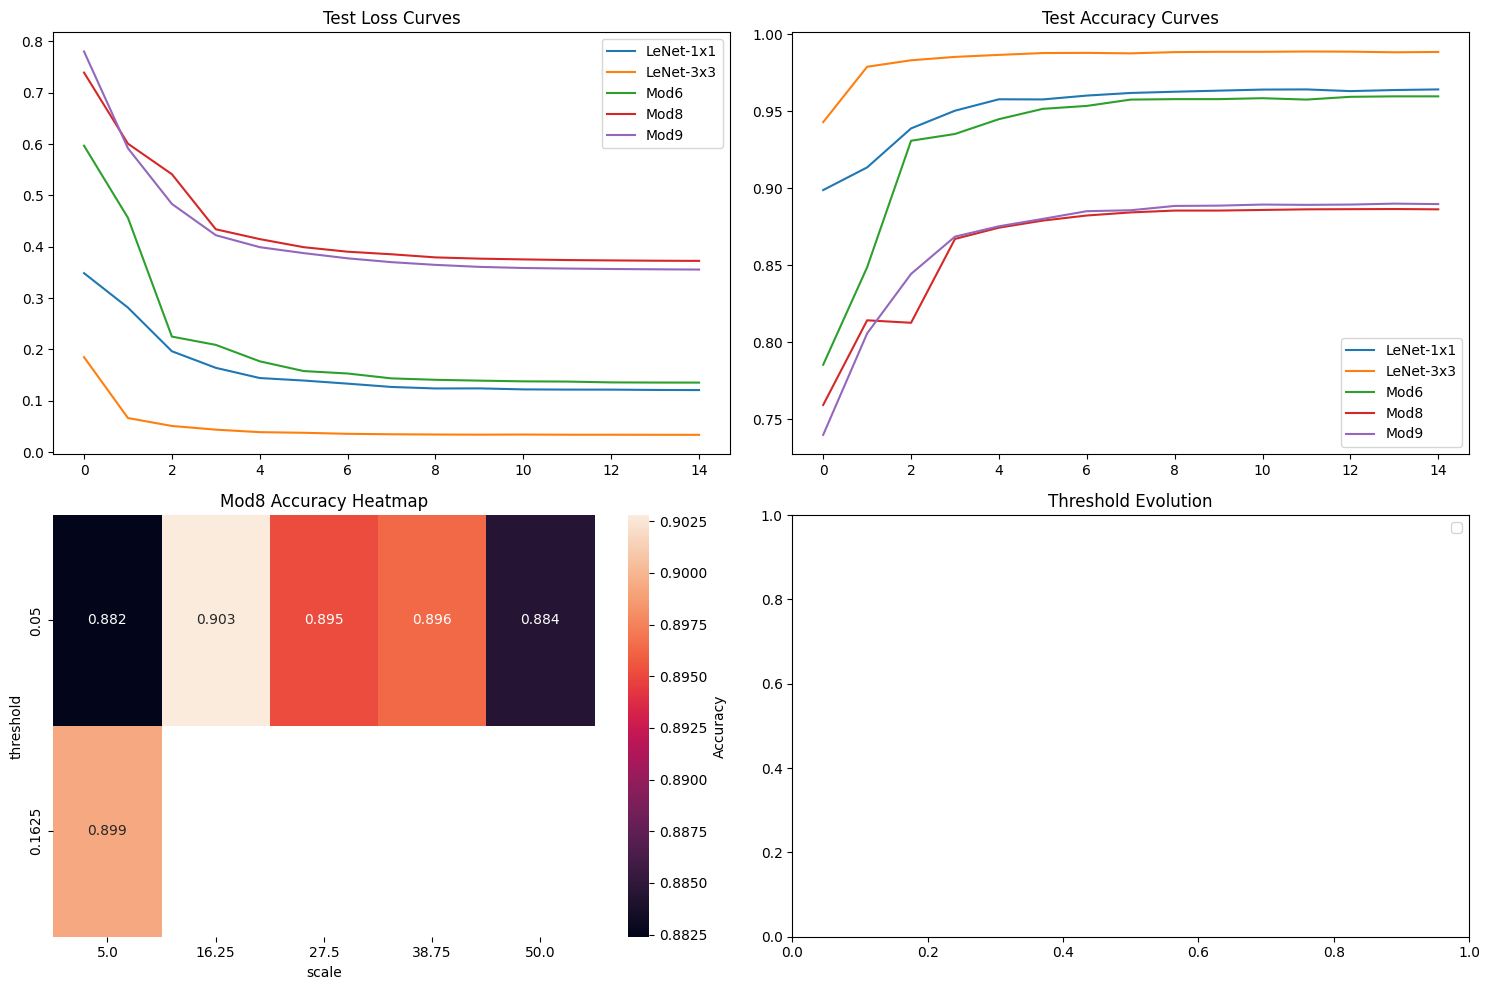


=== Final Metrics ===
Model           |     Params |           FLOPs | Size (MB) | Accuracy
------------------------------------------------------------
LeNet-1x1       |  1,609,226 |       3,237,632 |     6.14 | 0.9641
LeNet-3x3       |  1,199,882 |      11,992,448 |     4.58 | 0.9884
Mod6            |  1,183,166 |       2,382,208 |     4.52 | 0.9596
Mod8            |  1,183,260 |       1,180,928 |     4.52 | 0.8863
Mod9            |  1,183,260 |       1,180,928 |     4.52 | 0.8897


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Visualization ---
plt.figure(figsize=(15, 10))

# 1) Test Loss
plt.subplot(2, 2, 1)
for name, metrics in all_metrics.items():
    plt.plot(metrics['test_loss'], label=name)
plt.title('Test Loss Curves')
plt.legend()

# 2) Test Accuracy
plt.subplot(2, 2, 2)
for name, metrics in all_metrics.items():
    plt.plot(metrics['test_acc'], label=name)
plt.title('Test Accuracy Curves')
plt.legend()

# 3) Mod8 Accuracy Heatmap
plt.subplot(2, 2, 3)
sweep_df = pd.DataFrame(sweep_results)
heatmap_data = sweep_df.pivot(index='threshold', columns='scale', values='accuracy')
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    mask=heatmap_data.isnull(),        # mask missing combos
    cbar_kws={'label': 'Accuracy'}
)
plt.title('Mod8 Accuracy Heatmap')

# 4) Threshold Evolution
plt.subplot(2, 2, 4)
for name, metrics in all_metrics.items():
    thr_means = []
    for epoch in metrics.get('thresholds', []):
        conv1 = epoch.get('conv1', {})
        thr = conv1.get('threshold')
        if thr is not None:
            thr_means.append(np.mean(thr))
    if thr_means:
        plt.plot(thr_means, label=f'{name} Threshold')
plt.title('Threshold Evolution')
plt.legend()

plt.tight_layout()
plt.savefig('results.png')
plt.show()

# --- Final Metrics ---
print("\n=== Final Metrics ===")
print(f"{'Model':<15} | {'Params':>10} | {'FLOPs':>15} | {'Size (MB)':>8} | {'Accuracy':>8}")
print("-"*60)
for name, metrics in all_metrics.items():
    print(
        f"{name:<15} | "
        f"{metrics['params']:10,} | "
        f"{metrics['flops']:15,} | "
        f"{metrics['model_size']:8.2f} | "
        f"{metrics['test_acc'][-1]:.4f}"
    )


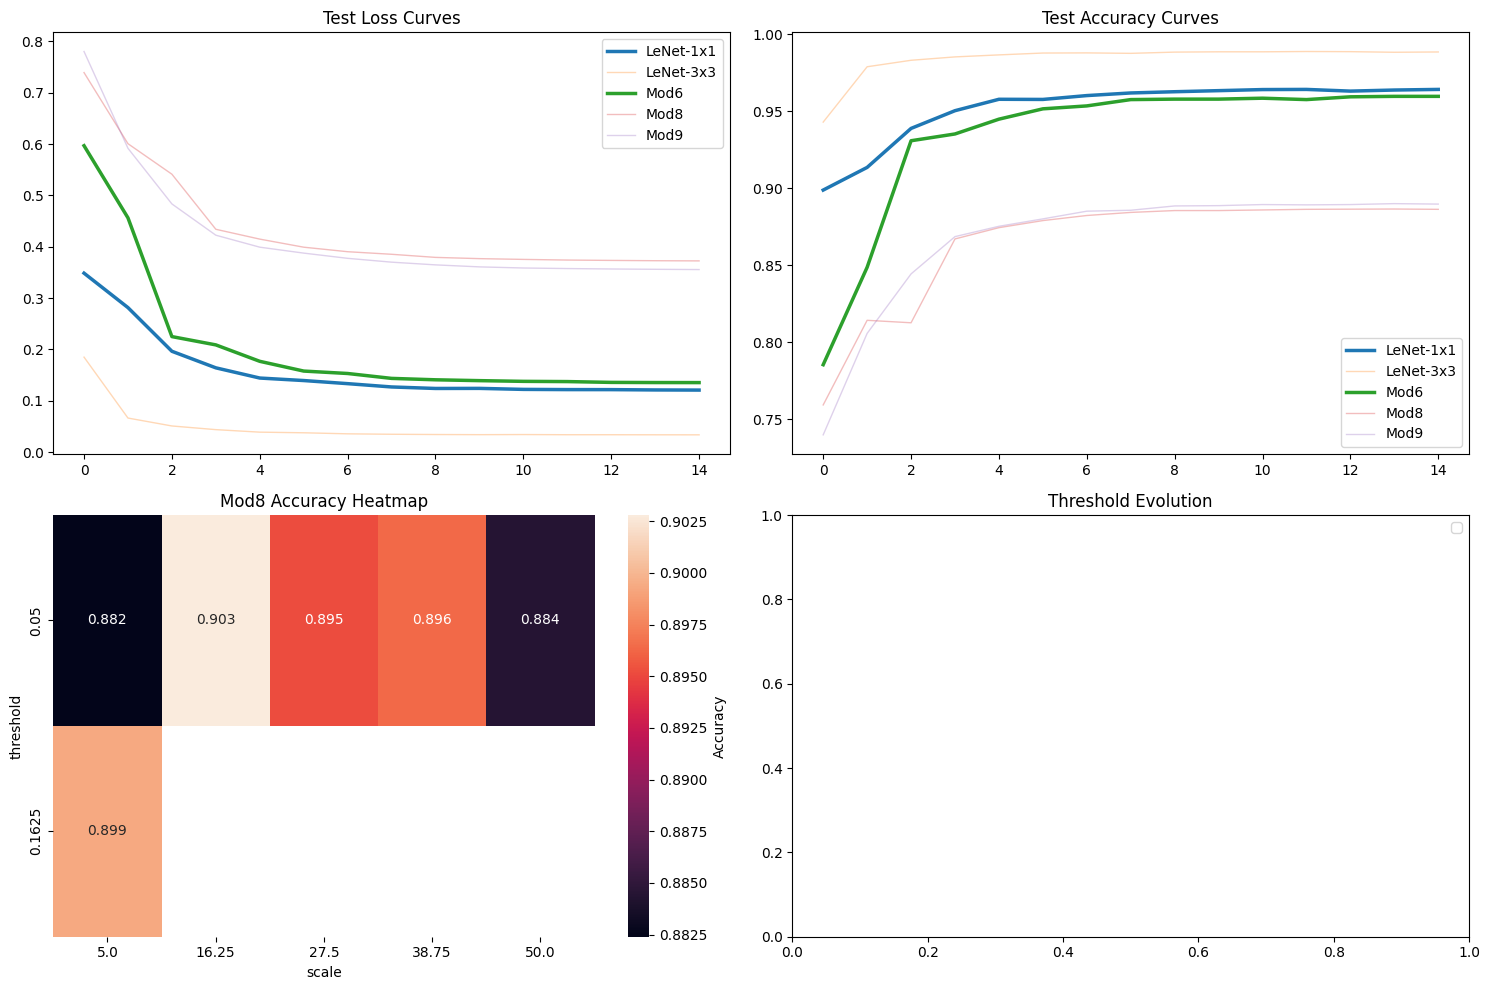

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# models to emphasize
highlight = {'lenet-1x1', 'mod6'}

plt.figure(figsize=(15, 10))

# 1) Test Loss
plt.subplot(2, 2, 1)
for name, metrics in all_metrics.items():
    lw    = 2.5 if name.lower() in highlight else 1.0
    alpha = 1.0 if name.lower() in highlight else 0.3
    plt.plot(metrics['test_loss'], label=name, linewidth=lw, alpha=alpha)
plt.title('Test Loss Curves')
plt.legend()

# 2) Test Accuracy
plt.subplot(2, 2, 2)
for name, metrics in all_metrics.items():
    lw    = 2.5 if name.lower() in highlight else 1.0
    alpha = 1.0 if name.lower() in highlight else 0.3
    plt.plot(metrics['test_acc'], label=name, linewidth=lw, alpha=alpha)
plt.title('Test Accuracy Curves')
plt.legend()

# 3) Mod8 Accuracy Heatmap (unchanged)
plt.subplot(2, 2, 3)
sweep_df = pd.DataFrame(sweep_results)
heatmap_data = sweep_df.pivot(index='threshold', columns='scale', values='accuracy')
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".3f",
    mask=heatmap_data.isnull(),
    cbar_kws={'label': 'Accuracy'}
)
plt.title('Mod8 Accuracy Heatmap')

# 4) Threshold Evolution
plt.subplot(2, 2, 4)
for name, metrics in all_metrics.items():
    thr_means = []
    for epoch in metrics.get('thresholds', []):
        conv1 = epoch.get('conv1', {})
        thr   = conv1.get('threshold')
        if thr is not None:
            thr_means.append(np.mean(thr))
    if thr_means:
        lw    = 2.5 if name.lower() in highlight else 1.0
        alpha = 1.0 if name.lower() in highlight else 0.3
        plt.plot(thr_means, label=name, linewidth=lw, alpha=alpha)
plt.title('Threshold Evolution')
plt.legend()

plt.tight_layout()
plt.savefig('results.png', dpi=300)  # higher DPI for paper
plt.show()


Epoch 1: 100%|██████████| 938/938 [00:15<00:00, 58.64it/s]


Epoch 1 completed


Epoch 2: 100%|██████████| 938/938 [00:16<00:00, 57.42it/s]


Epoch 2 completed


Epoch 3: 100%|██████████| 938/938 [00:15<00:00, 60.27it/s]


Epoch 3 completed


Epoch 4: 100%|██████████| 938/938 [00:15<00:00, 59.09it/s]


Epoch 4 completed


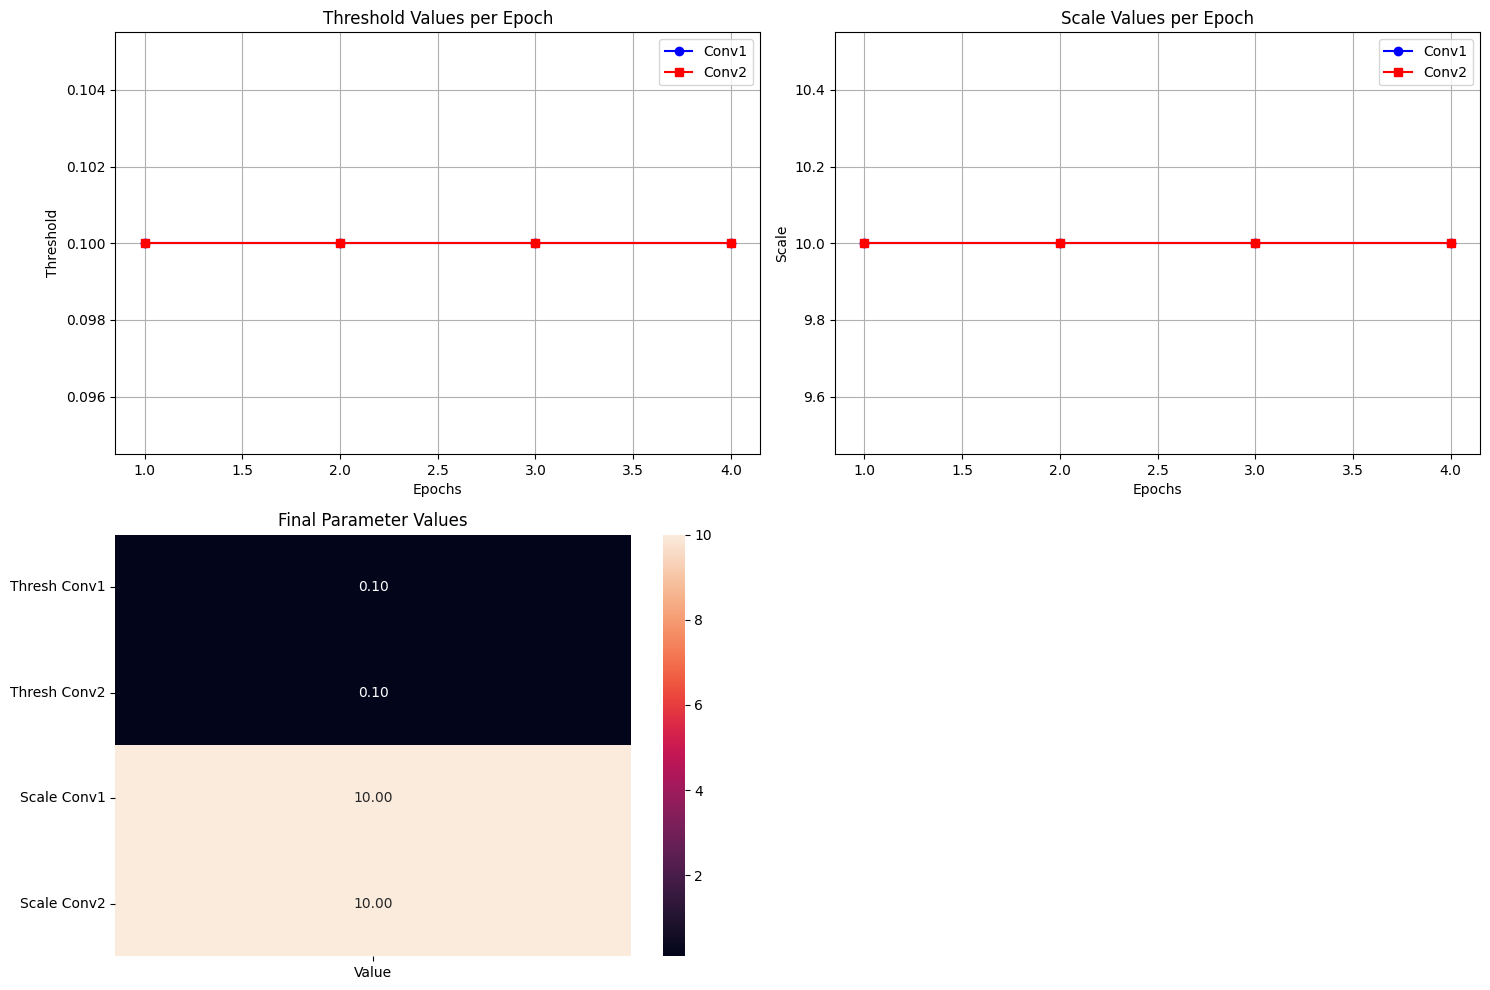

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Hyperparam Metrics Collection
hyperparam_metrics = {
    'threshold_conv1': [],
    'scale_conv1': [],
    'threshold_conv2': [],
    'scale_conv2': [],
    'epochs': []
}

# Modified Training Loop
def train_model(model, train_loader, test_loader, epochs=4):
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(4):
        model.train()
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
        # Collect parameters after each epoch
        if isinstance(model, nn.DataParallel):
            conv1 = model.module.conv1
            conv2 = model.module.conv2
        else:
            conv1 = model.conv1
            conv2 = model.conv2
            
        hyperparam_metrics['threshold_conv1'].append(conv1.threshold.item())
        hyperparam_metrics['scale_conv1'].append(conv1.scale.item())
        hyperparam_metrics['threshold_conv2'].append(conv2.threshold.item())
        hyperparam_metrics['scale_conv2'].append(conv2.scale.item())
        hyperparam_metrics['epochs'].append(epoch+1)
        
        print(f'Epoch {epoch+1} completed')

# Visualization Code
def plot_metrics(hyperparam_metrics):
    plt.figure(figsize=(15, 10))
    
    # Threshold Progression
    plt.subplot(2, 2, 1)
    plt.plot(hyperparam_metrics['epochs'], hyperparam_metrics['threshold_conv1'], 'bo-')
    plt.plot(hyperparam_metrics['epochs'], hyperparam_metrics['threshold_conv2'], 'rs-')
    plt.title('Threshold Values per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Threshold')
    plt.legend(['Conv1', 'Conv2'])
    plt.grid(True)

    # Scale Progression
    plt.subplot(2, 2, 2)
    plt.plot(hyperparam_metrics['epochs'], hyperparam_metrics['scale_conv1'], 'bo-')
    plt.plot(hyperparam_metrics['epochs'], hyperparam_metrics['scale_conv2'], 'rs-')
    plt.title('Scale Values per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Scale')
    plt.legend(['Conv1', 'Conv2'])
    plt.grid(True)

    # Heatmap of Final Parameters
    plt.subplot(2, 2, 3)
    final_params = np.array([
        hyperparam_metrics['threshold_conv1'][-1:], 
        hyperparam_metrics['threshold_conv2'][-1:],
        hyperparam_metrics['scale_conv1'][-1:], 
        hyperparam_metrics['scale_conv2'][-1:]
    ])
    sns.heatmap(final_params, annot=True, fmt=".2f", 
                xticklabels=['Value'], 
                yticklabels=['Thresh Conv1', 'Thresh Conv2', 'Scale Conv1', 'Scale Conv2'])
    plt.title('Final Parameter Values')

    plt.tight_layout()
    plt.show()

# Initialize model
model = SamePadOptimizedInertialNet()
model = nn.DataParallel(model).cuda()

# Load datasets
transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# Train and plot
train_model(model, train_loader, train_loader)
plot_metrics(hyperparam_metrics)